In [7]:
import sys
sys.path.append("..")
sys.path.append("../neurontree/")

from computation import file_manager as fm
import NeuronTree as nt
import pandas as pd
import networkx as nx
import numpy as np

# Load file

In [14]:
N = fm.load_swc_file("../data/EC3-80604.CNG.swc")

There are 2-3 soma points. The location and the radius of the soma is estimated based on their mean.


# Plotting

Each NeuronTree object comes with its own plotting function `draw_2D()`. The parameter `projection` let's you choose which 2D projection to plot.

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

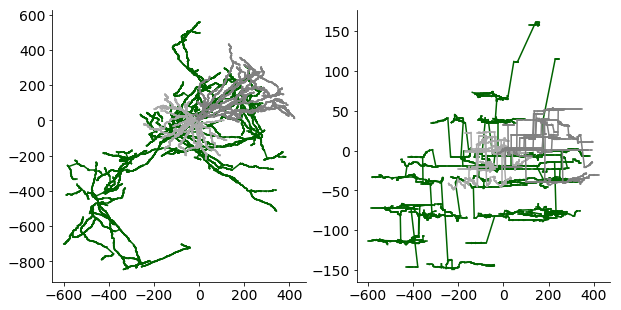

In [15]:
fig = plt.figure(figsize=(10,5))
ax1 = plt.subplot(121)
N.draw_2D(fig, ax=ax1, projection='xy')

ax2= plt.subplot(122)
N.draw_2D(fig, ax=ax2, projection='xz')

sns.despine()

In case you want to check out all of the three possible 2D projections at once you can also use the provided `show_threeview()`

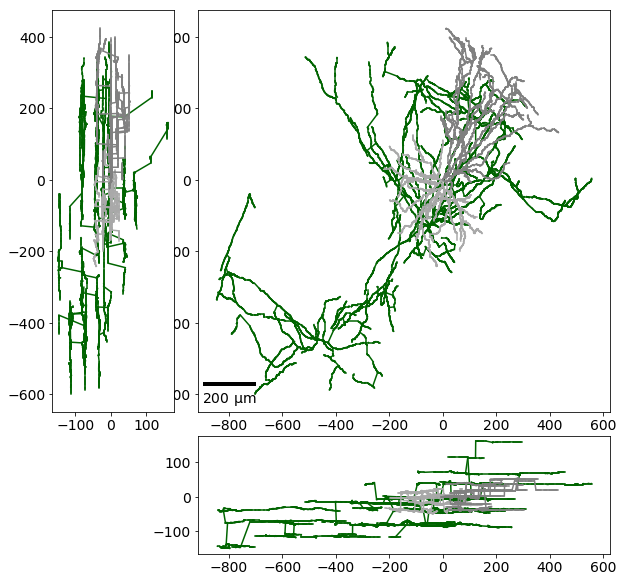

In [16]:
from neurontree.plotting import show_threeview

fig = plt.figure(figsize=(10,10))
show_threeview(N, fig)

### Plotting axon and dendrites indepedently

The above plot is a bit busy. The axon is large and entangled with the dendrites, so you might want to look at axons and dendrites independently.

In [13]:
Axon = N.get_axonal_tree()
Dendrites = N.get_dendritic_tree()

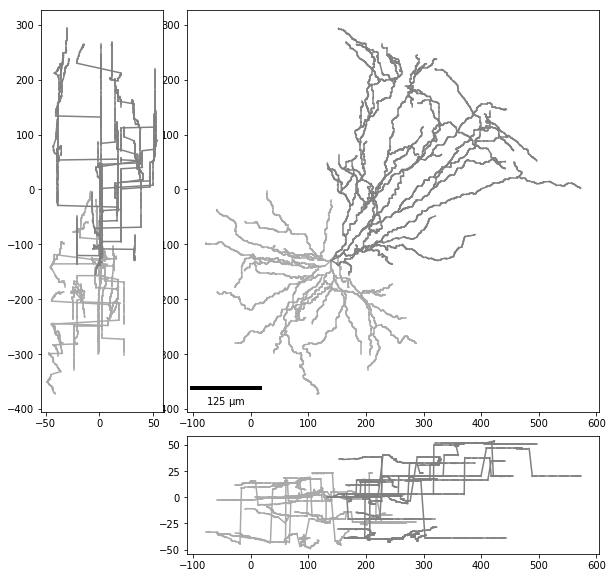

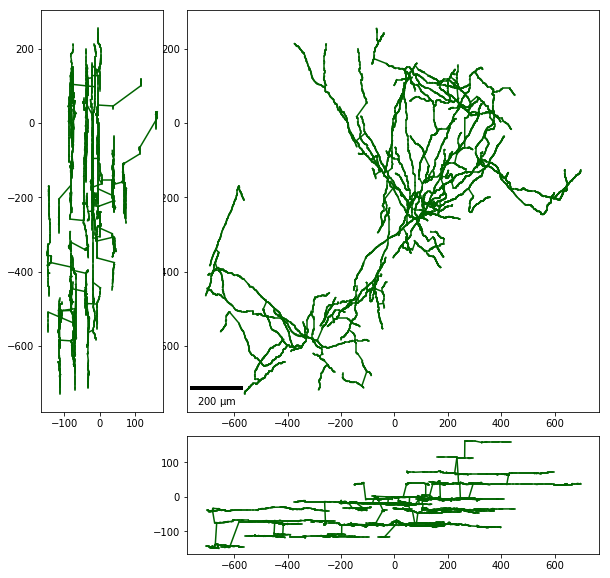

In [9]:
dendrite_fig = plt.figure(figsize=(10,10))
show_threeview(Dendrites, dendrite_fig)
plt.title('Dendrites')

axon_fig = plt.figure(figsize=(10,10))
show_threeview(Axon, axon_fig)
plt.title('Axon')

# Resampling and the topological minor of a reconstruction

Reconstruction files can have several thousand nodes. Sometimes it can make sense to reduce a reconstruction by e.g. resampling or different techniques. MorphoPy offers two functions for this: `resample_tree(dist)` and `get_topological_minor()`.

`resample_tree(dist)` returns a new NeuronTree with all points resampled to have the specified distance `dist`. 

In [ ]:
TODO

`get_topological_minor()` reduces the reconstruction to its branch points and tips.

Text(0.5, 0.98, 'Topological minor of the dendrites')

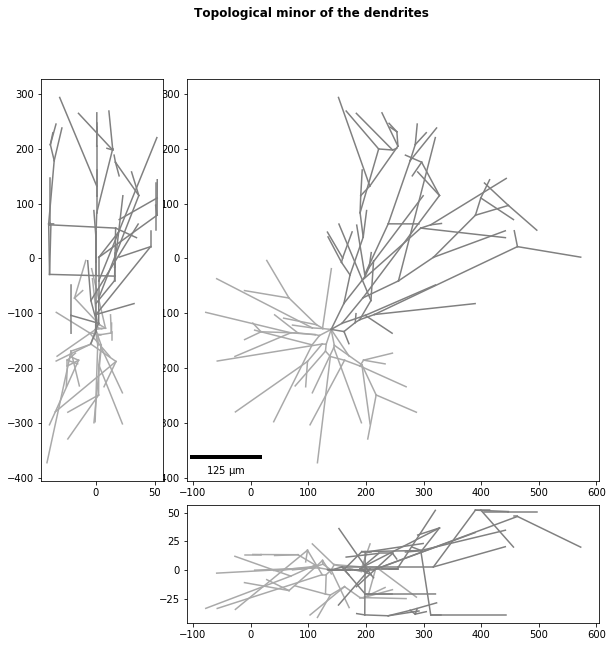

In [29]:
D = Dendrites.get_topological_minor()

fig = plt.figure(figsize=(10,10))
show_threeview(D, fig)
plt.suptitle('Topological minor of the dendrites', weight='bold')

A nice thing to note is that the original path length of a now reduced edge is kept as an edge attribute `path_length`.

In [27]:
total_length_unreduced = np.sum(list(Dendrites.get_segment_length(dist='path_length').values()))
total_length_unreduced

12014.243070272307

In [28]:
total_length_reduced = np.sum(list(D.get_segment_length(dist='path_length').values()))
total_length_reduced


12014.243070272307

# Feature representations

## Compute the Persistence Diagram

By default MorphoPy implements four different distance functions for persistence diagrams: radial distance to soma, path length to soma, height to soma, and branch order (to be found in computations.persistence_functions).


In [12]:
from computation.persistence_functions import path_length, radial_distance, height, branch_order
from computation.feature_presentation import get_persistence

In [16]:
filter_function = path_length

df = get_persistence(N.get_topological_minor(), f=filter_function) 
# we pass the topological minor here since persistence only operates on branch points anyways
df.head()

,birth,death,node_id,node_type
0,486.033861,470.121741,7911,4
1,522.786674,486.810094,3914,4
2,1994.380115,1908.622770,14377,2
3,850.798590,829.044053,19423,2
4,1056.353000,1049.563000,15814,2


However, one can also provide a custom distance function. It only needs to follow the form `function(networkx.DiGraph(), node_id_end, node_id_start)` and return the distance between start node and end node.

In [23]:
import numpy as np
def custom_distance(G, u, v):
    """
    Returns a distance between nodes u and v, which both are part of the graph given in G.
    """
    n = G.node[u]['pos']
    r = G.node[v]['pos']
    return np.dot(n, r)

In [22]:
df = get_persistence(N.get_topological_minor(), f=custom_distance) 
# we pass the topological minor here since persistence only operates on branch points anyways
df.head()

,birth,death,node_id,node_type
0,1733.0580,5611.0040,7890,4
1,13201.1053,18801.1695,3914,4
2,25189.1594,-27419.2678,14310,2
3,47205.7964,50601.7300,19423,2
4,37369.8922,38927.5021,15881,2


## Compute Morphometric Statistics

MorphoPy offers a default selection of 28 single valued morphometric statistics.

In [17]:
from computation.feature_presentation import compute_Morphometric_Statistics

In [18]:
compute_Morphometric_Statistics(N)

,0
min_branch_angle,11.866878
max_path_dist_to_soma,2492.136804
median_path_angle,19.363753
max_path_angle,119.564177
log_max_tortuosity,0.822798
tree_asymmetry,0.814848
max_thickness,0.420000
width,1021.850000
median_intermediate_segment_pl,40.044120
total_length,32329.041344


However, you might want to compute only a subset of these features or something completely different. The neurontree object allows you to query several different distributions and values. Below you find a subset of the computations done in the `compute_Morphometric_Statistics()` method. For more use cases check out the documentation of the neurontree.

You feel like using the command line tool but want different statistics? No problem, just fill in your code into the `compute_Morphometric_Statistics()` method.

In [19]:
z = dict()

# number of branch points
z['branch_points'] = N.get_branchpoints().size

# x, y and z extend of the neuron: max - min
extend = N.get_extend()

z['width'] = extend[0]
z['depth'] = extend[1]
z['height'] = extend[2]

# returns all tips of the reconstruction
tips = N.get_tips()
z['tips'] = tips.size
root = N.get_root()
z['stems'] = len(N.edges(root))

z['total_length'] = np.sum(list(nx.get_edge_attribute_names(N.get_graph(), 'path_length').values()))

# get all radii
radii = nx.get_node_attribute_names(N.get_graph(), 'radius')
# delete the soma
radii.pop(root)

z['avg_thickness'] = np.mean(list(radii.values()))
z['max_thickness'] = np.max(list(radii.values()))

R = N.get_topological_minor()
segment_length = R.get_segment_length()
terminal_segment_pl = [item[1] for item in segment_length.items() if item[0][1] in tips]
intermediate_segment_pl = [item[1] for item in segment_length.items() if item[0][1] not in tips]

z['max_segment_path_length'] = np.max(list(segment_length.values()))
z['median_intermediate_segment_pl'] = np.median([0] + intermediate_segment_pl)
z['median_terminal_segment_pl'] = np.median(terminal_segment_pl)


branch_angles = R.get_branch_angles()
z['max_branch_angle'] = np.max(branch_angles)
z['min_branch_angle'] = np.min(branch_angles)
z['mean_branch_angle'] = np.mean(branch_angles)

# get maximal degree within data
z['max_degree'] = np.max([item[1] for item in R.get_graph().out_degree().items() if item[0] != root])

# get tree asymmetry
weights, psad = R.get_psad()
if np.sum(list(weights.values())) != 0:
    z['tree_asymmetry'] = np.sum([weights[k]*psad[k] for k in psad.keys()])/np.sum(list(weights.values()))
else:
    z['tree_asymmetry'] = 0
    
pd.DataFrame(z, index=[0])

,avg_thickness,branch_points,depth,height,max_branch_angle,max_degree,max_segment_path_length,max_thickness,mean_branch_angle,median_intermediate_segment_pl,median_terminal_segment_pl,min_branch_angle,stems,tips,total_length,tree_asymmetry,width
0,0.235766,216,1402.95,310.68,178.914616,2,583.515986,0.42,95.860954,40.04412,54.73532,11.866878,9,224,32329.041344,0.814848,1021.85


## Compute Density Maps

In [18]:
# TODO

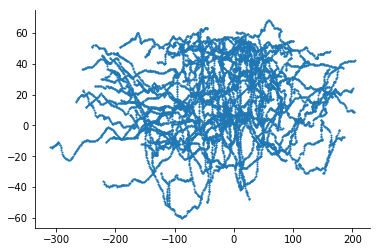

## Compute Morphometric Statistics